## Save animation to file(s)

This example shows how to use to save animation directly to MP4 video file or to single frame images. Points in bold indicate code related to the encoder.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import NpOptiX
from plotoptix.utils import make_color, map_to_colors

**1. Setup callbacks:** simply rotate the light source around the scene.

In [2]:
class params():
    fps = 25
    duration = 20
    dt = 2*np.pi / (fps*duration)
    p = [20, 12, 0]
    t = 0
    n = 0

def compute(rt: NpOptiX, delta: int) -> None:
    params.t += params.dt
    params.p = [20*np.cos(params.t), 12, 20*np.sin(params.t)]
    params.n += 1
    
# optionally, save every frame to a separate file using save_image() method
def update(rt: NpOptiX) -> None:
    rt.update_light("light1", pos=params.p)
    #rt.save_image("frame_{:05d}.png".format(params.n))
    
def redraw(rt):
    imgplot.set_data(rt._img_rgba)
    plt.draw()

Prepare the output figure, create raytracer:

<IPython.core.display.Javascript object>


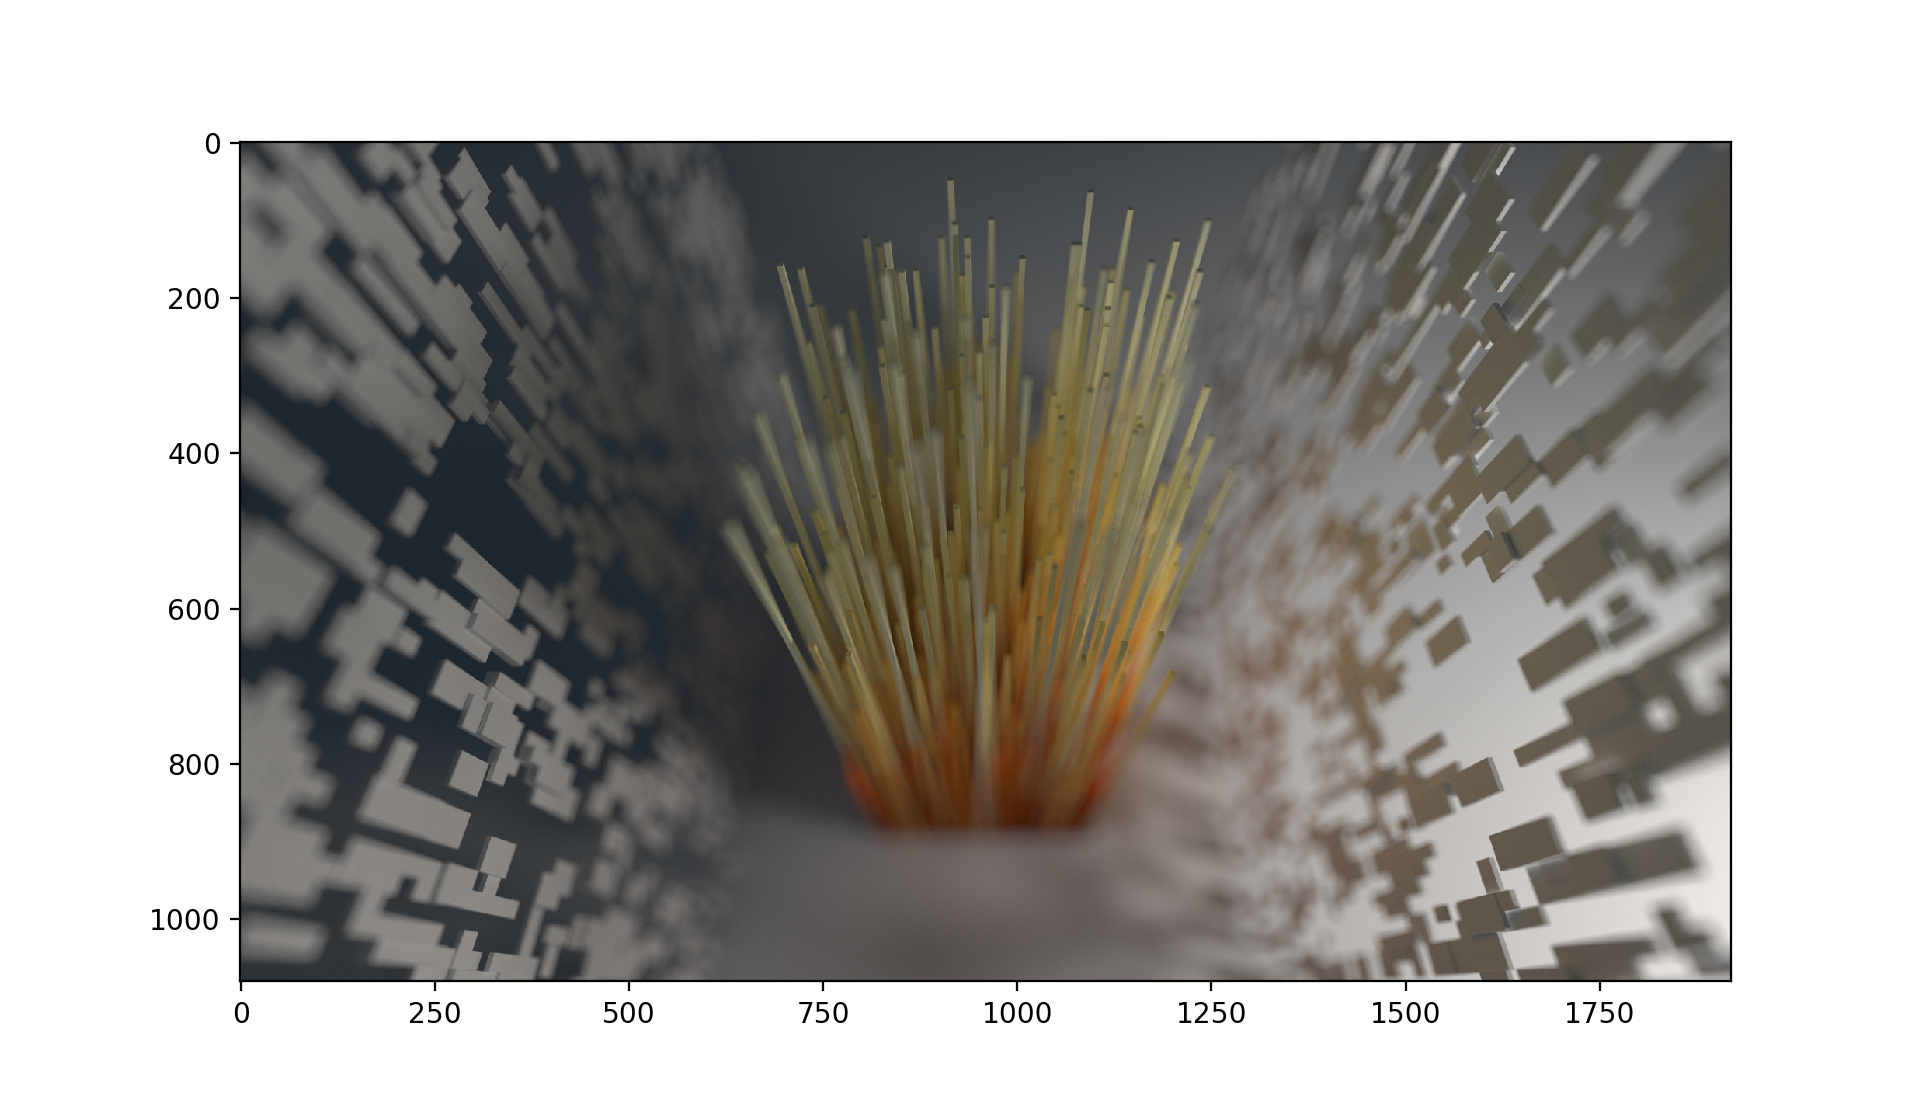

In [3]:
#width = 1920; height = 1080 # use high res if more compute power is at hand
width = 960; height = 540

plt.figure(1, figsize=(9.5, 5.5))
plt.tight_layout()
imgplot = plt.imshow(np.zeros((height, width, 4), dtype=np.uint8))

In [4]:
optix = NpOptiX(on_scene_compute=compute,
                on_rt_completed=update,
                on_launch_finished=redraw,
                width=width, height=height,
                start_now=False)

**2. Initialize encoder:** set constant bitrate in Mb/s, or use one of predefined settings. Note that not all players are capable of decoding all settings.

In [5]:
#optix.encoder_create(fps=20, bitrate=8)
optix.encoder_create(fps=20, bitrate=4, profile="High")
#optix.encoder_create(fps=20, profile="High444", preset="Lossless")

Configure ray tracer:

In [6]:
optix.set_param(min_accumulation_step=256,    # 1 animation frame = 256 accumulation frames
                max_accumulation_frames=512)  # accumulate 512 frames when paused
optix.set_uint("path_seg_range", 5, 10)

exposure = 0.8; gamma = 2.2
optix.set_float("tonemap_exposure", exposure) # sRGB tonning
optix.set_float("tonemap_igamma", 1 / gamma)
optix.add_postproc("Gamma")
#optix.setup_denoiser(blend=0.25)             # ~128 accumulation frames is enough for a high
                                              # quality if denoiser is used instead of Gamma

optix.set_ambient([0.01, 0.02, 0.03])
optix.set_background(0)

Prepare a simple scene objects, camera and lights:

In [7]:
N = 2000
dx = 0.05; max_x = 5
ny = 60; my = 4; max_h = 13
nz = 50; mz = 2; max_z = 8

px = (2 * np.random.randint(2, size=N) - 1) * (1 - 0.03 * np.random.rand(N))
py = np.random.randint(ny, size=N)
pz = np.random.randint(2*nz+1, size=N) - nz
p = np.stack((max_x * px, (max_h/ny) * py, (max_z/nz) * pz)).T

pu = [dx, 0, 0]
pv = np.zeros((N, 3)); pv[:,1] = (max_h/ny) * (np.random.randint(my, size=N) + 1)
pw = np.zeros((N, 3)); pw[:,2] = (max_z/nz) * (np.random.randint(mz, size=N) + 1)

M = 70
r = 2
x = np.linspace(-r, r, M)
z = np.linspace(-r, r, M)
qx, qz = np.meshgrid(x, z)
q = np.stack((qx.flatten(), np.zeros(M*M), qz.flatten())).T
qv = np.zeros(q.shape); qv[:,1] = (0.1 + 11 * np.random.rand(M*M)**5)[:]
quw = 0.98 * 2 * r / (M - 1)

Note `make_color()` method, it preserves colors from the selected palette when gamma correction is applied.

In [8]:
optix.set_data("plane", geom="Parallelograms", c=[0.9, 0.91, 0.92],
               pos=[[-100, -0.01, -100]], u=[200, 0, 0], v=[0, 0, 200])
optix.set_data("sides", geom="Parallelepipeds", pos=p, u=pu, v=pv, w=pw, c=0.94)
optix.set_data("blocks", geom="Parallelepipeds", pos=q, u=[quw, 0, 0], v=qv, w=[0, 0, quw],
               c=make_color(map_to_colors(-qv[:,1], "YlOrBr"), exposure=exposure, gamma=gamma))

In [9]:
optix.setup_camera("cam1", cam_type="DoF",
                   eye=[0, 15, 5], target=[0, 7, 0], up=[0, 0, -1],
                   aperture_radius=0.3, aperture_fract=0.2,
                   fov=60, focal_scale=0.75, blur=0.2)
optix.setup_light("light1", pos=[15, 12, 15], color=[45, 43, 41], radius=2)

Start raytracing:

In [10]:
optix.start()

**3. Start encoder**, save the full 360 deg loop:

In [11]:
optix.encoder_start("lights.mp4", params.fps * params.duration)

Check where we are with the animation:

In [12]:
print(optix.encoding_frames(), optix.encoded_frames())

500 21


Optionally, stop before completing all frames (it is possible to restart it again):

In [13]:
optix.encoder_stop()

Close the ray tracing instance:

In [14]:
optix.close()